In [1]:
!pip install accelerate==0.19.0 datasets==2.12.0 transformers==4.29.2 evaluate==0.4.0 scikit-learn text2num tokenizers torch>=2.0.0 torchmetrics tqdm wandb 


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, urllib.request, inspect, functools, collections, gc
from tqdm.auto import tqdm
from typing import List, Optional, Union

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import transformers, datasets
from transformers import AutoTokenizer, EncoderDecoderModel

import wandb

# keep datasets in memory if < 8 GB
datasets.config.IN_MEMORY_MAX_SIZE = 8 * 1024**3

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: simonemele999. Use `wandb login --relogin` to force relogin


True

# Config

In [4]:
from enum import Enum, auto


class AnswerType(Enum):
    UNKNOWN = auto()
    SPAN = auto()
    YES_NO = auto()
    FLUENCY = auto()
    COUNTING = auto()
    MULTIPLE_CHOICE = auto()

    def __str__(self):
        return self.name.lower()

    @classmethod
    def list(cls, return_unknown=True):
        return [str(c) for c in cls if return_unknown or c != AnswerType.UNKNOWN]

In [5]:
from dataclasses import dataclass
import os
from typing import Optional


@dataclass
class Config:
    @dataclass
    class Dataset:
        train_url: str = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
        test_url: str = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"

        # data_dir: str = os.path.join("..", "input", "dataset", "data")
        data_dir: str = "data"

        raw_dir: str = os.path.join(data_dir, "raw")
        train_data_raw: str = os.path.join(raw_dir, "train.json")
        test_data_raw: str = os.path.join(raw_dir, "test.json")

        annotated_dir: str = os.path.join(data_dir, "annotated")
        train_data_annotated: str = os.path.join(annotated_dir, "train.json")
        test_data_annotated: str = os.path.join(annotated_dir, "test.json")

        readable_dir: str = os.path.join(data_dir, "readable")
        train_data_readable: str = os.path.join(readable_dir, "train.txt")
        test_data_readable: str = os.path.join(readable_dir, "test.txt")

        filtered_dir: str = os.path.join(data_dir, "filtered")
        splitted_dir: str = os.path.join(data_dir, "splitted")
        processed_dir: str = os.path.join(data_dir, "processed")
        train_dir: str = os.path.join(data_dir, "train")

        def train_no_history(self, model_name: str, split="") -> str:
            return os.path.join(self.train_dir, "train_no_history", model_name, split)

        def train_with_history(self, model_name: str, split="") -> str:
            return os.path.join(self.train_dir, "train_with_history", model_name, split)

    class Checkpoints:
        def __init__(
            self, distil_roberta="distilroberta-base", bert_tiny="prajjwal1/bert-tiny"
        ) -> None:
            self.distil_roberta = distil_roberta
            self.bert_tiny = bert_tiny

    class Models:
        def __init__(
            self,
            model_dir_name="models",
            checkpoint_dir_name="checkpoints",
            final_checkpoint_name="final.pt",
        ) -> None:
            self.__model_dir = model_dir_name
            self.__checkpoints_dir_name = checkpoint_dir_name
            self.__final_checkpoint_name = final_checkpoint_name

        def model_dir(self, model_name, history: Optional[bool] = None):
            if history is None:
                history_str = ""
            elif history:
                history_str = "history"
            else:
                history_str = "no_history"
            return os.path.join(self.__model_dir, model_name, history_str)

        def checkpoints_dir(self, model_name, history: Optional[bool]):
            return os.path.join(
                self.model_dir(model_name, history=history), self.__checkpoints_dir_name
            )

        def checkpoint(self, model_name, history: Optional[bool]):
            return os.path.join(
                self.model_dir(model_name, history=history),
                self.__final_checkpoint_name,
            )

    @dataclass
    class Preprocessing:
        encoder_max_length: int
        decoder_max_length: int
        stride: int = 196
        use_window: bool = False
        max_history_length: int = 4

    @dataclass
    class WandbConfig:
        """Specify the parameters of `wandb.init`"""

        project: str = "nlp_assignment2"
        entity: str = "nlp_assignment2"

    dataset: Dataset = Dataset()
    checkpoints: Checkpoints = Checkpoints()
    models: Models = Models()

    # remove all span answers longer than span_max_length words
    span_max_length: int = 37
    # ignore loss of rationales longer than rationale_max_length
    rationale_max_length: int = 150

    encoder_max_length = 512
    # decoder_max_length = 350
    decoder_max_length = 64

    preprocessing = Preprocessing(encoder_max_length, decoder_max_length)
    generation = dict(penalty_alpha=0.6, top_k=6)

    wandbConfig = WandbConfig()

In [6]:
CONFIG: Config = Config()

# Utils

In [7]:
import inspect
import itertools
import os
import random
from typing import Dict, Literal

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datasets
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from text_to_num import text2num



class AvgValue:
    def __init__(self, initial_value=0.0) -> None:
        self.__value = initial_value
        self.__last_value = initial_value
        self.__n = 0

    def update(self, value, n=1):
        self.__last_value = value
        old_n = self.__n
        self.__n += n
        self.__value = old_n / self.__n * self.__value + n / self.__n * value

    def value(self):
        return self.__value

    @property
    def last_value(self):
        return self.__last_value

    @property
    def n(self):
        return self.__n


################# Reproducibility ######################à
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# Using a generator and the following function as `worker_init_fn` preserves reproducibility when using DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def create_reproducible_dataloader(*args, **kwargs):
    generator = torch.Generator()
    return DataLoader(
        *args,
        **kwargs,
        #   worker_init_fn=seed_worker,
        #   generator=generator
    )


###############################################################


def create_dirs_for_file(file_path):
    dir = os.path.dirname(file_path)
    ensure_dir_exists(dir)


def ensure_dir_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)


def is_number(string: str) -> bool:
    """
    Check whether a string is a number, both written or numeric.

    Args:
    - string (str): The string to be checked.

    Returns:
    - True if the string is a number, False otherwise.
    """
    if string.isdigit():
        return True
    try:
        # Try to convert written number to integer
        text2num(string, "en", relaxed=True)
        return True
    except ValueError:
        return False


def batched_function(fn, scalar_output=True):
    def execute_on_batch(batch):
        examples = [
            fn(dict(zip(batch.keys(), values))) for values in zip(*batch.values())
        ]

        if scalar_output:
            return {
                key: [example[key] for example in examples]
                for key in examples[0].keys()
            }

        return {
            key: list(itertools.chain(*(example[key] for example in examples)))
            for key in examples[0].keys()
        }

    return execute_on_batch


def create_dataframe(dataset: datasets.DatasetDict):
    dataset.set_format("pandas")

    dataset_ = []
    for split, ds in dataset.items():
        split_df = ds[:]
        split_df["split"] = split
        dataset_.append(split_df)
    dataset_ = pd.concat(dataset_)
    dataset_.reset_index(drop=True, inplace=True)
    dataset.reset_format()

    return dataset_


def explode_qa(dataset: pd.DataFrame):
    dataset = dataset.explode(["questions", "answers"])
    dataset.rename(columns={"questions": "question", "answers": "answer"}, inplace=True)

    questions = pd.json_normalize(dataset["question"])
    questions = questions[["turn_id", "input_text"]]
    questions.rename(
        columns={"input_text": "question", "turn_id": "turn"}, inplace=True
    )

    answers = pd.json_normalize(dataset["answer"])
    answers = answers[
        ["input_text", "span_text", "span_start", "span_end", "answer_type"]
    ]
    answers.rename(
        columns={"input_text": "answer", "span_text": "rationale"}, inplace=True
    )

    dataset.reset_index(inplace=True)
    dataset.drop(["index", "question", "answer"], axis=1, inplace=True)
    dataset = dataset.join(questions)
    dataset = dataset.join(answers)

    cols = dataset.columns.tolist()
    cols.append(cols.pop(cols.index("last_turn")))
    cols.append(cols.pop(cols.index("qa_length")))
    cols.append(cols.pop(cols.index("split")))
    return dataset[cols]


def plot_answer_type_distribution(qa_dataset: pd.DataFrame):
    plot_distribution(qa_dataset, field="answer_type", hue="split")


def plot_distribution(dataset: pd.DataFrame, field: str, hue: str = None):
    if hue is not None:
        dataset = dataset.groupby(hue)

    distribution = dataset[field].value_counts(normalize=True)
    distribution = distribution.apply(lambda x: np.round(x, decimals=3) * 100)
    distribution = distribution.rename("frequency").reset_index()
    ax = sns.barplot(distribution, x=field, y="frequency", hue=hue)

    for i in ax.containers:
        ax.bar_label(
            i,
        )

    plt.tight_layout()
    plt.show()


def show_inputs(tokenizer, data, inputs):
    for k, v in inputs.items():
        print(f"{k:<27}: {v}")
    print()

    for idx in range(len(inputs["input_ids"])):
        show_input(tokenizer, data, inputs, idx)
        print()


def show_input(tokenizer, data, inputs, idx):
    sample_idx = (
        inputs["overflow_to_sample_mapping"][idx]
        if "overflow_to_sample_mapping" in inputs
        else idx
    )

    input_ids = np.asarray(inputs["input_ids"][idx])
    passage_mask = np.asarray(inputs["passage_mask"][idx])
    rationale_labels = np.asarray(inputs["rationale_labels"][idx])
    rationale_start = inputs["rationale_start"][idx]
    rationale_end = inputs["rationale_end"][idx]
    labels = np.asarray(inputs["labels"][idx])
    decoder_attention_mask = np.asarray(inputs["decoder_attention_mask"][idx])

    passage = input_ids[passage_mask.astype(np.bool_)]
    rationale = input_ids[rationale_labels > 0]
    assert np.all(rationale == input_ids[rationale_start:rationale_end])
    answer = labels[decoder_attention_mask.astype(np.bool_)]

    print("Input:", tokenizer.decode(input_ids))
    print("Q:", data["question"][sample_idx])
    print("P (-):", data["passage"][sample_idx])
    print("P (+):", tokenizer.decode(passage))
    print("R (-):", data["rationale"][sample_idx])
    print("R (+):", tokenizer.decode(rationale))
    print("A (-):", data["answer"][sample_idx])
    print("A (+):", tokenizer.decode(answer))
    print("History:", data["history"][sample_idx])


def logits_to_class(logits, task: Literal["binary", "multiclass"]) -> torch.LongTensor:
    if task == "binary":
        return (logits > 0.0).long()
    elif task == "multiclass":
        return torch.argmax(logits, dim=-1).long()
    else:
        raise ValueError(
            "Invalid task. Supported values are 'binary' and 'multiclass'."
        )


def prepare_model_inputs(
    model: nn.Module, inputs: Dict[str, torch.Tensor]
) -> Dict[str, torch.Tensor]:
    forward_signature = set(inspect.signature(model.forward).parameters)
    inputs = {
        argument: value.to(model.device)
        for argument, value in inputs.items()
        if argument in forward_signature
    }
    return inputs


# Preprocessing

In [8]:
import itertools
import re
import string
import transformers

import numpy as np

from typing import List, Tuple


def answer_to_idx(answer: str) -> int:
    if answer.lower() == "yes":
        return 0
    if answer.lower() == "no":
        return 1
    return 2


def idx_to_answer(idx: int) -> str:
    if idx == 0:
        return "yes"
    if idx == 1:
        return "no"
    return None


class CoQADatasetPreprocessing:
    def __init__(
        self,
        tokenizer: transformers.PreTrainedTokenizer = None,
        label_pad_token_id=-100,
        encoder_max_length=512,
        decoder_max_length=350,
        stride=196,
        use_window=False,
        max_history_length=4,
    ) -> None:
        self.tokenizer = tokenizer
        self.label_pad_token_id = label_pad_token_id
        self.encoder_max_length = encoder_max_length
        self.decoder_max_length = decoder_max_length
        self.stride = stride
        self.use_window = use_window
        self.max_history_length = max_history_length

    def explode_questions(self, example):
        questions = example["questions"]
        answers = example["answers"]
        histories = []

        for idx in range(len(questions)):
            history = self.__create_history(idx, questions, answers)
            histories.append(history)

        output = {
            "id": [example["id"]] * example["qa_length"],
            "turn": [question_item["turn_id"] for question_item in questions],
            "question": [question_item["input_text"] for question_item in questions],
            "answer": [answer_item["input_text"] for answer_item in answers],
            "rationale": [answer_item["span_text"] for answer_item in answers],
            "span_start": [answer_item["span_start"] for answer_item in answers],
            "span_end": [answer_item["span_end"] for answer_item in answers],
            "answer_type": [answer_item["answer_type"] for answer_item in answers],
            "history": histories,
            "history_length": [len(history) for history in histories],
        }
        for key, value in example.items():
            if key not in output:
                output[key] = [value] * example["qa_length"]
        return output

    def __create_history(self, current_index, questions, answers):
        history = [
            {
                "question": questions[i]["input_text"],
                "answer": answers[i]["input_text"],
                "turn": questions[i]["turn_id"],
            }
            for i in range(current_index)
        ]
        return history

    def preprocess_texts(self, example):
        handle_rationale = "rationale" in example
        if handle_rationale:
            example = self.__fix_rationale(example)

        example = self.__preprocess_passage(example, handle_rationale=handle_rationale)
        example = self.__preprocess_questions(example)
        example = self.__preprocess_answers(example)

        return example

    def __fix_rationale(self, example):
        rationale, span_start, span_end = fix_rationale(
            example["passage"],
            example["rationale"],
            example["span_start"],
            example["span_end"],
        )

        example["rationale"] = rationale
        example["span_start"] = span_start
        example["span_end"] = span_end

        return example

    def __preprocess_passage(self, example, handle_rationale=True):
        return self.__fix_passage_white_space(
            example, handle_rationale=handle_rationale
        )

    def __preprocess_questions(self, example):
        example["question"] = white_space_fix(example["question"])
        for item in example.get("history", []):
            item["question"] = white_space_fix(item["question"])
        return example

    def __preprocess_answers(self, example):
        if "answer" in example:
            example["answer"] = self.__preprocess_answer(example["answer"])
        for item in example.get("history", []):
            item["answer"] = self.__preprocess_answer(item["answer"])
        return example

    def __preprocess_answer(self, answer):
        answer = white_space_fix(answer)
        answer = strip_non_alphanumeric_chars(answer)
        return answer

    def __fix_passage_white_space(self, example, handle_rationale=True):
        passage = example["passage"]
        if handle_rationale:
            span_start = example["span_start"]
            span_end = example["span_end"]

            if span_end - span_start > 0:
                # assert rationale has already been fixed
                assert (
                    passage[span_start].isalnum() and passage[span_end - 1].isalnum()
                ), "Rationale must start and end with alphanumeric characters. You must fix it before."

            passage_start = white_space_fix(passage[:span_start])
            rationale = white_space_fix(passage[span_start:span_end])
            passage_end = white_space_fix(passage[span_end:])

            passage = " ".join((passage_start, rationale, passage_end))
            span_start = len(passage_start) + 1
            span_end = span_start + len(rationale)

            assert rationale == passage[span_start:span_end]

            example["passage"] = passage
            example["rationale"] = rationale
            example["span_start"] = span_start
            example["span_end"] = span_end
        else:
            example["passage"] = white_space_fix(passage)

        return example

    def process_data_to_model_inputs(
        self,
        examples,
        add_history=False,
        padding=False,
    ) -> transformers.BatchEncoding:
        assert (
            self.tokenizer is not None
        ), "A tokenizer is required to prepare the inputs for the model"
        process_rationale = "rationale" in examples
        process_answer = "answer" in examples

        sentences = [examples["question"], examples["passage"]]

        if add_history:
            sentences[0] = self.__concat_history_and_question(
                examples["history"], examples["question"]
            )

        inputs = self.tokenizer(
            *sentences,
            padding=padding,
            truncation="only_second",
            max_length=self.encoder_max_length,
            stride=self.stride,
            return_overflowing_tokens=self.use_window,
            return_offsets_mapping=True,
        )
        if process_answer:
            outputs = self.tokenizer(
                examples["answer"],
                padding=padding,
                truncation=True,
                max_length=self.decoder_max_length,
            )

        offset_mapping = inputs["offset_mapping"]
        if self.use_window:
            sample_map = lambda i: inputs["overflow_to_sample_mapping"][i]
        else:
            sample_map = lambda i: i

        yes_no_types = []
        yng_labels = []

        passage_masks = []
        rationale_starts = []
        rationale_ends = []
        rationale_labels = []
        decoder_input_ids = []
        labels = []
        decoder_attention_masks = []

        ids = []
        turns = []

        # # store the presence of the rationale in the passage for at least one row
        # rationale_in_passage = [False] * len(examples["question"])
        for i, offset in enumerate(offset_mapping):
            sample_idx = sample_map(i)
            sequence_ids = inputs.sequence_ids(i)

            passage_start, passage_end = self.__find_passage(sequence_ids)
            passage_masks.append(
                self.__create_mask(sequence_ids, passage_start, passage_end + 1)
            )

            if process_rationale:
                start_char = examples["span_start"][sample_idx]
                end_char = examples["span_end"][sample_idx]
                rationale_start, rationale_end = self.__char2token_rationale_span(
                    offset, (passage_start, passage_end), (start_char, end_char)
                )
                rationale_starts.append(rationale_start)
                rationale_ends.append(rationale_end)
                rationale_labels_ = self.__create_mask(
                    sequence_ids, rationale_start, rationale_end, dtype=np.float32
                )
                rationale_labels_[passage_masks[-1] == 0] = self.label_pad_token_id
                rationale_labels.append(rationale_labels_)

                # rationale_in_passage[sample_idx] |= rationale_start != -1

            if process_answer:
                # Remove <eos> from decoder_input_ids
                decoder_input_ids_ = outputs.input_ids[sample_idx][:-1]
                # Remove <bos> from labels
                labels_ = outputs.input_ids[sample_idx].copy()[1:]
                labels_ = [
                    self.label_pad_token_id
                    if token == self.tokenizer.pad_token_id
                    else token
                    for token in labels_
                ]
                decoder_attention_mask = outputs.attention_mask[sample_idx][:-1]

                decoder_input_ids.append(decoder_input_ids_)
                labels.append(labels_)
                decoder_attention_masks.append(decoder_attention_mask)

                yng_label = answer_to_idx(examples["answer"][sample_idx])
                is_yes_no = yng_label < 2
                assert is_yes_no == (examples["answer_type"][sample_idx] == "yes_no")
                yng_labels.append(yng_label)
                yes_no_types.append(int(is_yes_no))

            ids.append(examples["id"][sample_idx])
            if "turn" in examples:
                turns.append(examples["turn"][sample_idx])

        # if process_rationale:
        #     for sample_idx, is_rationale_in_passage in enumerate(rationale_in_passage):
        #         if not is_rationale_in_passage:
        #             warnings.warn(f"The rationale is never contained in the passage. Id: {examples['id'][sample_idx]}, turn:{examples['turn'][sample_idx]}")

        inputs["passage_mask"] = passage_masks
        if process_rationale:
            inputs["rationale_start"] = rationale_starts
            inputs["rationale_end"] = rationale_ends
            inputs["rationale_labels"] = rationale_labels
        if process_answer:
            inputs["decoder_input_ids"] = decoder_input_ids
            inputs["labels"] = labels
            inputs["decoder_attention_mask"] = decoder_attention_masks
            inputs["yng_label"] = yng_labels
            inputs["yes_no"] = yes_no_types
        inputs["id"] = ids
        if len(turns) > 0:
            inputs["turn"] = turns

        return inputs

    def __concat_history_and_question(self, histories, questions):
        outputs = []
        for history, question in zip(histories, questions):
            history_str = self.__create_history_str(history)
            history_question = self.tokenizer.sep_token.join((history_str, question))
            outputs.append(history_question)
        return outputs

    def __create_history_str(self, history):
        history_items = reversed(
            tuple(itertools.islice((reversed(history)), self.max_history_length))
        )
        qa_pairs = []
        for item in history_items:
            qa = (item["question"], item["answer"])
            qa = self.tokenizer.sep_token.join(qa)
            qa_pairs.append(qa)
        return self.tokenizer.sep_token.join(qa_pairs)

    def __find_passage(self, sequence_ids: List[int]) -> Tuple[int, int]:
        """
        Find the start and the end of the passage w.r.t. the tokens.
        """

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        passage_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        passage_end = idx - 1

        return passage_start, passage_end

    def __char2token_rationale_span(
        self,
        token_to_span: List[Tuple[int, int]],
        passage_token_span: Tuple[int, int],
        rationale_char_span: Tuple[int, int],
    ) -> Tuple[int, int]:
        """
        Map the rationale span from char indexes to token indexes
        """
        passage_start, passage_end = passage_token_span
        start_char, end_char = rationale_char_span

        # If the rationale is not fully inside the passage, returns (-1, -1)
        if (
            token_to_span[passage_start][0] > start_char
            or token_to_span[passage_end][1] < end_char
        ):
            return (-1, -1)

        # Otherwise it's the start and end token positions
        idx = passage_start
        while idx <= passage_end and token_to_span[idx][0] <= start_char:
            idx += 1
        start_position = idx - 1

        idx = passage_end
        while idx >= passage_start and token_to_span[idx][1] >= end_char:
            idx -= 1
        end_position = idx + 1

        return start_position, end_position + 1

    def __create_mask(self, arr, start, end, dtype=np.int8):
        mask = np.zeros_like(arr, dtype=dtype)
        mask[start:end] = 1
        return mask


def remove_articles_(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)


def white_space_fix(text: str):
    return " ".join(text.split())


def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)


def lower(text):
    return text.lower()


def normalize_text(text, remove_articles=False):
    """Lower text and remove punctuation, articles and extra whitespace."""
    text = remove_punc(lower(text))
    if remove_articles:
        text = remove_articles_(text)
    return white_space_fix(text)


def normalize_answer(text):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return normalize_text(text, remove_articles=True)


def strip_non_alphanumeric_chars(text: str):
    """
    Removes trailing and leading non alpha-numeric characters from a given string.
    """
    start_index = 0
    while start_index < len(text) and not text[start_index].isalnum():
        start_index += 1

    end_index = len(text) - 1
    while end_index > start_index and not text[end_index].isalnum():
        end_index -= 1

    return text[start_index : end_index + 1]


def find_span(passage: str, text: str, span_start: int = None, span_end: int = None):
    if len(text) == 0:
        return (span_start, span_start)
    assert (
        text[0].isalnum() and text[-1].isalnum()
    ), "Text must begin and end with an alphanumeric character."

    start_idx = passage.find(text, span_start, span_end)
    end_idx = start_idx + len(text) - 1

    if start_idx == -1:
        raise ValueError("The text is not present in the passage.")

    # Find the beginning of the word in the passage
    while start_idx > 0 and passage[start_idx - 1].isalnum():
        start_idx -= 1

    # Find the end of the word in the passage
    while end_idx < len(passage) - 1 and passage[end_idx + 1].isalnum():
        end_idx += 1

    return start_idx, end_idx + 1


def fix_rationale(passage: str, rationale: str, span_start: int, span_end: int):
    rationale = strip_non_alphanumeric_chars(rationale)
    span_start, span_end = find_span(
        passage, rationale, span_start=span_start, span_end=span_end
    )
    return passage[span_start:span_end], span_start, span_end


# Model definition

In [9]:
from typing import List, Optional, Union, Tuple
from dataclasses import dataclass
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import AutoTokenizer, AutoModel, EncoderDecoderModel


@dataclass
class QAEncoderModelOutput(transformers.utils.ModelOutput):
    """
    Base class for outputs of question answering with rationale models.
    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided):
            Total rationale extraction loss is the sum of a Binary Cross-Entropy for the tokens in the passage.
        last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
            Sequence of hidden-states at the output of the last layer of the model.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
        rationale_logits (`torch.FloatTensor` of shape `(batch_size, sequence_length)`):
            Rationale classification scores (before Sigmoid).
        yng_logits (`torch.FloatTensor` of shape `(batch_size, 3)`):
            Yes/No/Generative scores (before Sigmoid).
    """

    loss: Optional[torch.FloatTensor] = None
    last_hidden_state: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
    rationale_logits: torch.FloatTensor = None
    yng_logits: torch.FloatTensor = None


@dataclass
class QAEncoderDecoderModelOutput(transformers.utils.ModelOutput):
    """
    Class for [`QAEncoderDecoderModel`] outputs.
    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided):
            Language modeling loss.
        logits (`torch.FloatTensor` of shape `(batch_size, sequence_length, config.vocab_size)`):
            Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
        past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of shape
            `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of shape
            `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.
            Contains pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
            blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.
        decoder_hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the decoder at the output of each layer plus the initial embedding outputs.
        decoder_attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.
            Attentions weights of the decoder, after the attention softmax, used to compute the weighted average in the
            self-attention heads.
        cross_attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.
            Attentions weights of the decoder's cross-attention layer, after the attention softmax, used to compute the
            weighted average in the cross-attention heads.
        encoder_last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder of the model.
        encoder_hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the encoder at the output of each layer plus the initial embedding outputs.
        encoder_attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.
            Attentions weights of the encoder, after the attention softmax, used to compute the weighted average in the
            self-attention heads.
        encoder_rationale_logits (`torch.FloatTensor` of shape `(batch_size, sequence_length)`):
            Encoder rationale classification scores (before Sigmoid).
        encoder_yng_logits (`torch.FloatTensor` of shape `(batch_size, 3)`):
            Encoder Yes/No/Generative scores (before Sigmoid).
    """

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
    decoder_hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    decoder_attentions: Optional[Tuple[torch.FloatTensor]] = None
    cross_attentions: Optional[Tuple[torch.FloatTensor]] = None
    encoder_last_hidden_state: Optional[torch.FloatTensor] = None
    encoder_hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    encoder_attentions: Optional[Tuple[torch.FloatTensor]] = None
    encoder_rationale_logits: Optional[torch.FloatTensor] = None
    encoder_yng_logits: torch.FloatTensor = None


class QAEncoderDecoderModel(transformers.EncoderDecoderModel):
    def __init__(
        self,
        encoder: transformers.PreTrainedModel,
        decoder: transformers.PreTrainedModel,
        config: Optional[transformers.EncoderDecoderConfig] = None,
    ):
        super(QAEncoderDecoderModel, self).__init__(
            encoder=encoder, decoder=decoder, config=config
        )

    def tie_weights(self):
        # tie encoder & decoder if needed
        if self.config.tie_encoder_decoder:
            # tie encoder and decoder base model
            encoder_base_model_prefix = self.encoder.base_model_prefix
            decoder_base_model_prefix = self.decoder.base_model_prefix
            self._tie_encoder_decoder_weights(
                self.encoder._modules[encoder_base_model_prefix],
                self.decoder._modules[decoder_base_model_prefix],
                self.decoder.base_model_prefix,
            )

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        passage_mask: Optional[torch.BoolTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
        past_key_values: Tuple[Tuple[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        # labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        teacher_force: Optional[float] = None,
        rationale_labels: Optional[torch.BoolTensor] = None,
        **kwargs,
    ) -> Union[Tuple, transformers.modeling_outputs.Seq2SeqLMOutput]:
        kwargs_encoder = {
            argument: value
            for argument, value in kwargs.items()
            if not argument.startswith("decoder")
        }

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                passage_mask=passage_mask,
                return_dict=return_dict,
                teacher_force=teacher_force,
                rationale_labels=rationale_labels,
                **kwargs_encoder,
            )

        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            encoder_outputs=encoder_outputs,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            # labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            token_type_ids=token_type_ids,
            **kwargs,
        )

        if not return_dict:
            return outputs + encoder_outputs[-2:]

        return QAEncoderDecoderModelOutput(
            **outputs,
            encoder_rationale_logits=encoder_outputs.rationale_logits,
            encoder_yng_logits=encoder_outputs.yng_logits,
        )


class QAEncoder(transformers.PreTrainedModel):
    base_model_prefix = "encoder"

    def __init__(self, encoder, config) -> None:
        super().__init__(config)
        self.config = config

        self.encoder = encoder
        self.rationale_head = TokenSelectionHead(config)
        self.yes_no_gen_head = YesNoGenHead(config)

        self.post_init()

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, nn.Linear):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        passage_mask: Optional[torch.Tensor] = None,
        # labels: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        teacher_force: Optional[float] = None,
        rationale_labels: Optional[torch.BoolTensor] = None,
        **kwargs,
    ) -> Union[Tuple, QAEncoderModelOutput]:
        assert passage_mask is not None, "Passage mask is required"

        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            # labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            **kwargs,
        )

        last_hidden_state = outputs[0]
        pooled_output = outputs[1]

        rationale_logits = self.rationale_head(last_hidden_state)

        passage_mask = passage_mask.unsqueeze(-1)
        p_rationale = torch.sigmoid(rationale_logits)
        # substitute the last_hidden_state[passage] with p_rationale * last_hidden_state[passage]
        # ideally, our network keeps only the span of the passage which represents the rationale
        if self.training:
            if teacher_force is not None:
                use_labels = torch.rand(rationale_labels.shape[0]) < teacher_force
                use_labels = use_labels.to(p_rationale.device)
                true_labels = rationale_labels.unsqueeze(-1).type(p_rationale.dtype)
                p_rationale = torch.where(use_labels.reshape(-1, 1, 1), true_labels, p_rationale)
        else:
            p_rationale = (p_rationale > self.config.p_rationale_threshold).type(p_rationale.dtype)

        weighted_passage_hidden_state = passage_mask * p_rationale * last_hidden_state
        qa_seq_hidden_state = (1 - passage_mask) * last_hidden_state
        last_hidden_state = weighted_passage_hidden_state + qa_seq_hidden_state

        yng_logits = self.yes_no_gen_head(weighted_passage_hidden_state, pooled_output)

        rationale_logits = rationale_logits.squeeze(-1)

        loss = None
        if not return_dict:
            output = (last_hidden_state,) + outputs[2:] + (rationale_logits,)
            return ((loss,) + output) if loss is not None else output

        return QAEncoderModelOutput(
            loss=loss,
            last_hidden_state=last_hidden_state,
            rationale_logits=rationale_logits,
            yng_logits=yng_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


class TokenSelectionHead(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.act_fn = nn.ReLU()
        self.hidden_to_logit = nn.Linear(config.hidden_size, 1, bias=False)

    def forward(self, hidden_states: torch.FloatTensor) -> torch.FloatTensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.act_fn(hidden_states)
        logits = self.hidden_to_logit(hidden_states)
        return logits


class YesNoGenHead(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.act_fn = nn.ReLU()
        self.hidden_to_logit = nn.Linear(config.hidden_size, 1, bias=False)
        self.softmax = nn.Softmax(dim=-2)

        classifier_dropout = (
            config.classifier_dropout
            if config.classifier_dropout is not None
            else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(2 * config.hidden_size, 3)

    def forward(
        self,
        rationale_weighted_hidden_states: torch.FloatTensor,
        pooled_output: torch.FloatTensor,
    ) -> torch.FloatTensor:
        rationale_weighted_hidden_states = self.dense(rationale_weighted_hidden_states)
        rationale_weighted_hidden_states = self.act_fn(
            rationale_weighted_hidden_states
        )  # BxTxD
        logits = self.hidden_to_logit(rationale_weighted_hidden_states)  # BxTx1
        attention_scores = self.softmax(logits)  # BxTx1
        weighted_tokens = attention_scores * rationale_weighted_hidden_states  # BxTxD
        weighted_pooled_output = torch.sum(weighted_tokens, dim=-2)  # BxD
        pooled_output = torch.cat(
            (weighted_pooled_output, pooled_output), dim=-1
        )  # Bx2D

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits


def initialize_cross_attention_layer_with_self_attention_layer(
    self_attention: nn.Module,
    cross_attention: nn.Module,
    cross_attention_layer_prefix: str,
):
    uninitialized_cross_attention_weights: List[str] = []
    if cross_attention.__class__ != self_attention.__class__:
        print(
            f"{cross_attention.__class__} and {self_attention.__class__} are not equal. In this case make sure that all encoder"
            " weights are correctly initialized."
        )

    def initialize_cross_attention_with_self_attention_recursively(
        self_attention_pointer: nn.Module,
        cross_attention_pointer: nn.Module,
        module_name: str,
        uninitialized_cross_attention_weights: List[str],
        depth=0,
    ):
        assert isinstance(self_attention_pointer, nn.Module) and isinstance(
            cross_attention_pointer, nn.Module
        ), f"{self_attention_pointer} and {cross_attention_pointer} have to be of type nn.Module"
        if hasattr(self_attention_pointer, "weight"):
            assert hasattr(cross_attention_pointer, "weight")
            cross_attention_pointer.weight.data = (
                self_attention_pointer.weight.data.clone().detach()
            )
            if hasattr(self_attention_pointer, "bias"):
                assert hasattr(cross_attention_pointer, "bias")
                cross_attention_pointer.bias.data = (
                    self_attention_pointer.bias.data.clone().detach()
                )
            return

        cross_attention_modules = cross_attention_pointer._modules
        self_attention_modules = self_attention_pointer._modules
        if len(self_attention_modules) > 0:
            assert (
                len(cross_attention_modules) > 0
            ), f"Cross-attention module {cross_attention_pointer} does not match self-attention module {self_attention_pointer}"

            all_cross_attention_weights = {
                module_name + "/" + sub_name
                for sub_name in cross_attention_modules.keys()
            }
            cross_attention_layer_pos = 0
            for name, module in self_attention_modules.items():
                if name.isdigit():
                    cross_attention_name = str(int(name) + cross_attention_layer_pos)
                    self_attention_name = name
                    if not isinstance(
                        self_attention_modules[self_attention_name],
                        type(cross_attention_modules[cross_attention_name]),
                    ) and len(cross_attention_modules) != len(self_attention_modules):
                        # this can happen if the name corresponds to the position in a list module list of layers
                        # in this case the decoder has added a cross-attention that the encoder does not have
                        # thus skip this step and subtract one layer pos from encoder
                        cross_attention_layer_pos -= 1
                        continue
                elif name not in cross_attention_modules:
                    continue
                elif depth > 500:
                    raise ValueError(
                        "Max depth of recursive function `initialize_cross_attention_with_self_attention` reached. It seems that there is"
                        " a circular dependency between two or more `nn.Modules` of your model."
                    )
                else:
                    self_attention_name = cross_attention_name = name
                initialize_cross_attention_with_self_attention_recursively(
                    self_attention_modules[self_attention_name],
                    cross_attention_modules[cross_attention_name],
                    module_name + "/" + name,
                    uninitialized_cross_attention_weights,
                    depth=depth + 1,
                )
                all_cross_attention_weights.remove(
                    module_name + "/" + cross_attention_name
                )

            uninitialized_cross_attention_weights += list(all_cross_attention_weights)

    # initialize weights recursively
    initialize_cross_attention_with_self_attention_recursively(
        self_attention,
        cross_attention,
        cross_attention_layer_prefix,
        uninitialized_cross_attention_weights,
    )
    if len(uninitialized_cross_attention_weights) > 0:
        warnings.warn(
            f"The following cross_attention weights were not initialized with self_attention weights: {uninitialized_cross_attention_weights}"
        )


def initialize_cross_attention_with_self_attention(model: EncoderDecoderModel):
    decoder_base_model_prefix = model.decoder.base_model_prefix
    for layer_idx in range(model.config.decoder.num_hidden_layers):
        decoder_layer = model.decoder._modules[decoder_base_model_prefix].encoder.layer[
            layer_idx
        ]
        cross_attention = decoder_layer.crossattention
        self_attention = decoder_layer.attention
        cross_attention_name = f"layer.{layer_idx}.crossattention"
        initialize_cross_attention_layer_with_self_attention_layer(
            self_attention, cross_attention, cross_attention_name
        )
    print("Cross-attention has been initialized with self-attention weights.")


def make_encoder_decoder_model(
    checkpoint,
    decoder_max_length,
    generation_kwargs,
    tokenizer: Optional[transformers.PreTrainedTokenizer] = None,
    initialize_cross_attention=True,
):
    tokenizer, encoder = make_qa_encoder(checkpoint, tokenizer=tokenizer)
    decoder = transformers.AutoModelForCausalLM.from_pretrained(
        checkpoint,
        is_decoder=True,
        add_cross_attention=True,
        decoder_start_token_id=tokenizer.bos_token_id,
    )

    config = transformers.EncoderDecoderConfig.from_encoder_decoder_configs(
        encoder.config,
        decoder.config,
        tie_encoder_decoder=True,
        decoder_start_token_id=tokenizer.cls_token_id,
        eos_token_id=tokenizer.sep_token_id,
        pad_token_id=tokenizer.pad_token_id,
        # sensible parameters for generation
        vocab_size=decoder.config.vocab_size,
        max_new_tokens=decoder_max_length,
        **generation_kwargs,
    )

    model = QAEncoderDecoderModel(encoder=encoder, decoder=decoder, config=config)
    if initialize_cross_attention:
        initialize_cross_attention_with_self_attention(model)

    return tokenizer, model


def make_qa_encoder(
    checkpoint, tokenizer: Optional[transformers.PreTrainedTokenizer] = None
):
    if tokenizer is None:
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    encoder = AutoModel.from_pretrained(checkpoint)
    encoder.config.p_rationale_threshold = 0.5
    encoder = QAEncoder(encoder, encoder.config)
    return tokenizer, encoder


# Losses

In [10]:
from dataclasses import dataclass
from typing import Dict, Optional, Protocol, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

_EPSILON = 1e-7


def apply_reduction(input: torch.Tensor, reduction: str, dim=0):
    if reduction == "none":
        return input

    if input.shape[0] == 0:
        input = torch.Tensor([0]).type(dtype=input.dtype).to(device=input.device)
    if reduction == "mean":
        return torch.mean(input, dim=dim)
    if reduction == "sum":
        return torch.sum(input, dim=dim)

    raise ValueError(
        "Invalid reduction. Supported values are 'none', 'mean' and 'sum'."
    )

def categorical_focal_loss_with_logits(input: torch.Tensor, target: torch.Tensor, weight: Optional[torch.Tensor]=None, alpha=1., gamma=2., reduction: str = "mean"):
    ce_loss = F.cross_entropy(input, target, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1-pt)**gamma * ce_loss

    if weight is not None:
        weight = weight[target.long()]
        loss *= weight

    return apply_reduction(loss, reduction=reduction)


class Loss(Protocol):
    def __call__(self, outputs, targets: Dict[str, torch.Tensor]) -> torch.FloatTensor:
        pass


class ComputeLoss(Protocol):
    def __call__(
        outputs, targets: Dict[str, torch.Tensor]
    ) -> Tuple[torch.FloatTensor, Dict[str, float]]:
        pass


def wrap_loss_fn(
    name: str, loss_fn: Loss
) -> Tuple[torch.FloatTensor, Dict[str, float]]:
    def loss(outputs, targets):
        loss_value = loss_fn(outputs, targets)
        return loss_value, {name: loss_value.item()}

    return loss


@dataclass
class Criterion:
    name: str
    loss_fn: Loss
    weight: float = 1.0


class UncertaintyLoss(nn.Module, ComputeLoss):
    def __init__(self, name: str, loss_fn: Loss, initial_weight: float = 1.0) -> None:
        super(UncertaintyLoss, self).__init__()
        self.name = name
        self.loss_fn = loss_fn
        log_sigma_square = -np.log(initial_weight)
        self.log_sigma_square = nn.Parameter(
            torch.tensor(log_sigma_square, requires_grad=True, dtype=torch.float32)
        )

    def forward(
        self, outputs, targets: Dict[str, torch.Tensor]
    ) -> Tuple[torch.FloatTensor, Dict[str, float]]:
        inner_loss = self.loss_fn(outputs, targets)
        # 1/sigma^2 * L + 2 log sigma
        weight = torch.exp(-self.log_sigma_square)
        loss = weight * inner_loss + self.log_sigma_square

        return loss, {
            self.name: inner_loss.item(),
            f"{self.name}_weight": weight.item(),
        }


# class UncertaintyLoss(nn.Module):
#     def __init__(self, *criteria: Criterion) -> None:
#         super(UncertaintyLoss, self).__init__()
#         self.criteria = criteria
#         weights = [criterion.weight for criterion in self.criteria]
#         log_square_sigmas = -np.log(weights)
#         self.log_square_sigmas = nn.Parameter(
#             torch.tensor(log_square_sigmas, requires_grad=True, dtype=torch.float32)
#         )

#     def forward(
#         self, outputs, targets: Dict[str, torch.Tensor]
#     ) -> Tuple[torch.FloatTensor, Dict[str, float]]:
#         losses = {}
#         total_loss = 0.0
#         for criterion, log_sigma_square in zip(self.criteria, self.log_square_sigmas):
#             loss = criterion.loss_fn(outputs, targets)
#             # 1/sigma^2 * L + 2 log sigma
#             weight = torch.exp(-log_sigma_square)
#             total_loss += weight * loss + log_sigma_square
#             losses[f"{criterion.name}_weight"] = weight.item()
#             losses[criterion.name] = loss.item()

#         return total_loss, losses


def generative_loss(
    logits: torch.FloatTensor,
    labels: torch.IntTensor,
    reduction: str = "mean",
    mask: torch.Tensor = None,
) -> torch.FloatTensor:
    if mask is not None:
        logits = logits[mask.bool()]
        labels = labels[mask.bool()]

    # swap seq_length with vocabulary dimension
    logits = torch.transpose(logits, 1, 2)  # batch_size x seq_length x vocab
    loss = F.cross_entropy(
        input=logits, target=labels, reduction="none"
    )  # batch_size x seq_length
    n_tokens_per_sample = torch.sum(labels != -100, dim=-1)  # batch_size
    n_tokens_per_sample = torch.clamp(n_tokens_per_sample, min=_EPSILON)
    loss = torch.sum(loss, dim=-1) / n_tokens_per_sample  # batch_size
    loss = apply_reduction(loss, reduction=reduction)
    return loss


class EncoderDecoderGenerativeLoss(Loss):
    def __init__(self, reduction: str = "mean") -> None:
        self.reduction = reduction

    def __call__(
        self,
        outputs,
        targets: Dict[str, torch.Tensor],
        mask: torch.Tensor = None,
    ) -> torch.FloatTensor:
        logits = outputs["logits"]
        labels = targets["labels"]

        return generative_loss(logits, labels, reduction=self.reduction, mask=mask)


# def rationale_loss(self, outputs, targets: Dict[str, torch.Tensor]) -> torch.FloatTensor:
def rationale_loss(
    logits: torch.FloatTensor,
    labels: torch.IntTensor,
    passage_mask: torch.IntTensor,
    max_rationale_length: int,
    reduction="mean",
    mask: torch.Tensor = None,
) -> torch.FloatTensor:
    """
    li = w * BCE(y_pred_i, y_true_i)
    , where w = w_positive if y_true_i is positive
            w = w_negative if y_true_i is negative
    w_positive = totals / positives
    w_negative = totals / negatives
    , where totals, positives and negatives are computed for each sequence

    Ls = sum_i=1..seq_length li / sum(w_i)
    L = sum_s=1..N Ls / N,
    , where N is the #sequences whose rationale length is <= max_rationale_length
    """

    # rationale_logits = outputs[self.rationale_logits_name]
    # rationale_labels = targets[self.rationale_labels_name]
    # passage_mask = targets[self.passage_mask_name]

    labels = labels * passage_mask

    rationale_lengths = torch.sum(labels, dim=-1)  # batch_size
    valid_rationales = rationale_lengths <= max_rationale_length
    if mask is not None:
        valid_rationales = valid_rationales & mask.bool()

    labels = labels[valid_rationales]
    passage_mask = passage_mask[valid_rationales]
    logits = logits[valid_rationales]

    # n_sequences = torch.sum(valid_rationales)

    totals = torch.sum(passage_mask, -1, keepdim=True)  # N x 1
    positives = torch.sum(labels, -1, keepdim=True)  # N x 1
    negatives = totals - positives  # N x 1
    totals = torch.clamp(totals, min=_EPSILON).float()
    weights = torch.where(
        labels == 1.0, totals / positives, totals / negatives
    )  # N x seq_length
    weights = torch.where(weights != torch.inf, weights, 0.0)  # N x seq_length
    weights = weights * passage_mask  # N x seq_length
    normalize_factor = torch.clamp(
        torch.sum(weights, dim=-1, keepdim=True), min=_EPSILON
    )
    weights = weights / normalize_factor  # N x seq_length
    # weights = weights * valid_rationales / n_sequences

    # N x seq_length
    per_token_loss = F.binary_cross_entropy_with_logits(
        input=logits,
        target=labels,
        weight=weights,
        reduction="none",
    )

    loss = torch.sum(per_token_loss, dim=-1)  # N
    return apply_reduction(loss, reduction=reduction)


class EncoderDecoderRationaleLoss(Loss):
    def __init__(self, max_rationale_length: int, reduction: str = "mean") -> None:
        self.max_rationale_length = max_rationale_length
        self.reduction = reduction

    def __call__(
        self,
        outputs,
        targets: Dict[str, torch.Tensor],
        mask: torch.Tensor = None,
    ) -> torch.FloatTensor:
        logits = outputs["encoder_rationale_logits"]
        labels = targets["rationale_labels"]
        passage_mask = targets["passage_mask"]

        return rationale_loss(
            logits,
            labels,
            passage_mask,
            self.max_rationale_length,
            reduction=self.reduction,
            mask=mask,
        )


class EncoderRationaleLoss(Loss):
    def __init__(self, max_rationale_length: int, reduction: str = "mean") -> None:
        self.max_rationale_length = max_rationale_length
        self.reduction = reduction

    def __call__(
        self,
        outputs,
        targets: Dict[str, torch.Tensor],
        mask: torch.Tensor = None,
    ) -> torch.FloatTensor:
        logits = outputs["rationale_logits"]
        labels = targets["rationale_labels"]
        passage_mask = targets["passage_mask"]

        return rationale_loss(
            logits,
            labels,
            passage_mask,
            self.max_rationale_length,
            reduction=self.reduction,
            mask=mask,
        )


def yes_no_gen_loss(
    logits: torch.FloatTensor,
    labels: torch.IntTensor,
    weight: Optional[torch.FloatTensor] = None,
    reduction="mean",
    mask: torch.Tensor = None,
) -> torch.FloatTensor:
    if mask is not None:
        logits = logits[mask.bool()]
        labels = labels[mask.bool()]

    if weight is not None:
        weight.to(logits.device)

    # loss = F.cross_entropy(logits, labels, weight=weight, reduction=reduction)
    loss = categorical_focal_loss_with_logits(logits, labels, weight=weight, reduction=reduction)
    return loss


class EncoderDecoderYNGLoss(Loss):
    def __init__(
        self, weight: Optional[torch.FloatTensor] = None, reduction: str = "mean"
    ) -> None:
        self.weight = weight
        self.reduction = reduction

    def __call__(
        self,
        outputs,
        targets: Dict[str, torch.Tensor],
        mask: torch.Tensor = None,
    ) -> torch.FloatTensor:
        logits = outputs["encoder_yng_logits"]
        labels = targets["yng_label"]

        return yes_no_gen_loss(
            logits, labels, weight=self.weight, reduction=self.reduction, mask=mask
        )


class EncoderYNGLoss(Loss):
    def __init__(
        self, weight: Optional[torch.FloatTensor] = None, reduction: str = "mean"
    ) -> None:
        self.weight = weight
        self.reduction = reduction

    def __call__(
        self,
        outputs,
        targets: Dict[str, torch.Tensor],
        mask: torch.Tensor = None,
    ) -> torch.FloatTensor:
        logits = outputs["yng_logits"]
        labels = targets["yng_label"]

        return yes_no_gen_loss(
            logits, labels, weight=self.weight, reduction=self.reduction, mask=mask
        )


class EncoderDecoderLoss(nn.Module):
    def __init__(
        self,
        max_rationale_length,
        yng_loss_weight=1.0,
        rationale_loss_weight=1.0,
        generative_loss_weight=1.0,
    ) -> None:
        super().__init__()

        self.yng_loss_weight = yng_loss_weight
        self.rationale_loss_weight = rationale_loss_weight
        self.generative_loss_weight = generative_loss_weight

        # weight = torch.Tensor([1 / 11.0, 1 / 9.0, 1 / 80.0])
        # weight = weight / torch.sum(weight)
        # weight = None
        self.yes_no_gen_loss_fn = EncoderDecoderYNGLoss()
        self.yes_no_gen_loss_fn = EncoderDecoderYNGLoss()
        self.rationale_loss_fn = EncoderDecoderRationaleLoss(
            max_rationale_length=max_rationale_length
        )
        self.generative_loss_fn = EncoderDecoderGenerativeLoss()

    def forward(
        self, outputs, targets: Dict[str, torch.Tensor]
    ) -> Tuple[torch.FloatTensor, Dict[str, float]]:
        is_generative = ~targets["yes_no"].bool()

        yng_loss = self.yes_no_gen_loss_fn(outputs, targets)
        rationale_loss = self.rationale_loss_fn(outputs, targets, mask=is_generative)
        generative_loss = self.generative_loss_fn(outputs, targets, mask=is_generative)

        total_loss = (
            self.yng_loss_weight * yng_loss
            + self.rationale_loss_weight * rationale_loss
            + self.generative_loss_weight * generative_loss
        )
        loss_logs = {
            "yng_loss": yng_loss.item(),
            "rationale_loss": rationale_loss.item(),
            "generative_loss": generative_loss.item(),
        }

        return total_loss, loss_logs


# Train

In [11]:
import os
import torch

import numpy as np


import transformers
import datasets

from dataclasses import dataclass
from typing import Any, Dict, Optional, Union

class LinearScheduler:
    def __init__(
        self, total_iters:int, start_value:float=1., end_value:float=0., fraction=0.7
    ):

        self.start_value = float(start_value)
        self.end_value = float(end_value)
        self.total_iters = total_iters
        self.fraction = fraction
        self._total_iters = fraction * total_iters
        self.current_step = 0

    def step(self):
        self.current_step += 1

    def get_value(self):
        if self.current_step > self._total_iters:
            return self.end_value
         
        return (
            self.start_value
            + (self.end_value - self.start_value)
            / self._total_iters
            * self.current_step
        )

class DummyScheduler:
    def step(self):
        pass

    def get_value(self):
        return 0.

class DummyLRScheduler:
    def __init__(self, optimizer: torch.optim.Optimizer) -> None:
        self.optimizer = optimizer

    def step(self):
        None

    def get_last_lr(self):
        return [group["lr"] for group in self.optimizer.param_groups]

    def state_dict(self):
        return {}


@dataclass
class DynamicPaddingCollatorForSeq2Seq:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.

    Args:
        tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
            The tokenizer used for encoding the data.
        model ([`PreTrainedModel`]):
            The model that is being trained. If set and has the *prepare_decoder_input_ids_from_labels*, use it to
            prepare the *decoder_input_ids*

            This is useful when using *label_smoothing* to avoid calculating loss twice.
        padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:

            - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
              sequence is provided).
            - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
              acceptable input length for the model if that argument is not provided.
            - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
        max_length (`int`, *optional*):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (`int`, *optional*):
            If set will pad the sequence to a multiple of the provided value.

            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (`int`, *optional*, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignored by PyTorch loss functions).
        return_tensors (`str`):
            The type of Tensor to return. Allowable values are "np", "pt" and "tf".
    """

    tokenizer: transformers.PreTrainedTokenizerBase
    model: Optional[Any] = None
    padding: Union[bool, str, transformers.utils.PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100
    return_tensors: str = "pt"

    def __call__(self, features, return_tensors=None):
        if return_tensors is None:
            return_tensors = self.return_tensors

        # We have to pad the labels and other features not in  `tokenizer.model_input_names` before calling `tokenizer.pad`
        # as `tokenizer.pad` method will pad only features in `tokenizer.model_input_names`
        tokenizer_input_names = set(self.tokenizer.model_input_names)
        for feature_name in features[0].keys():
            if feature_name not in tokenizer_input_names and isinstance(
                features[0][feature_name], list
            ):
                if feature_name.endswith("labels"):
                    self.pad_feature(feature_name, features, self.label_pad_token_id)
                else:
                    self.pad_feature(feature_name, features)

        features = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=return_tensors,
        )

        # prepare decoder_input_ids
        if (
            "labels" in features
            and "decoder_input_ids" not in features
            and self.model is not None
            and hasattr(self.model, "prepare_decoder_input_ids_from_labels")
        ):
            decoder_input_ids = self.model.prepare_decoder_input_ids_from_labels(
                labels=features["labels"]
            )
            features["decoder_input_ids"] = decoder_input_ids

        return features

    def pad_feature(self, feature_name, features, pad_id=0):
        items = (
            [feature[feature_name] for feature in features]
            if feature_name in features[0].keys()
            else None
        )
        # We have to pad the feature before calling `tokenizer.pad` as this method won't pad them and needs them of the
        # same length to return tensors.
        if items is not None:
            max_item_length = max(len(l) for l in items)
            if self.pad_to_multiple_of is not None:
                max_item_length = (
                    (max_item_length + self.pad_to_multiple_of - 1)
                    // self.pad_to_multiple_of
                    * self.pad_to_multiple_of
                )

            padding_side = self.tokenizer.padding_side
            for feature in features:
                remainder = [pad_id] * (max_item_length - len(feature[feature_name]))
                if isinstance(feature[feature_name], list):
                    feature[feature_name] = (
                        feature[feature_name] + remainder
                        if padding_side == "right"
                        else remainder + feature[feature_name]
                    )
                elif padding_side == "right":
                    feature[feature_name] = np.concatenate(
                        [feature[feature_name], remainder]
                    )
                else:
                    feature[feature_name] = np.concatenate(
                        [remainder, feature[feature_name]]
                    )


def save_checkpoint(
    model, optimizer, scheduler, epoch, step, checkpoint_counter, checkpoint_path
):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "epoch": epoch,
        "step": step,
        "checkpoint_counter": checkpoint_counter,
    }

    torch.save(checkpoint, checkpoint_path)


def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    epoch = checkpoint["epoch"]
    step = checkpoint["step"]
    checkpoint_counter = checkpoint["checkpoint_counter"]

    print(f"Loaded checkpoint from '{checkpoint_path}'")

    return model, optimizer, scheduler, epoch, step, checkpoint_counter

def prepare_inputs_for_train(
    dataset: datasets.DatasetDict,
    checkpoints: Dict[str, str],
    filename_fn,
    add_history=False,
    num_processes=None,
    verbose=True,
    **preprocessing_kwargs,
):
    for name, checkpoint in checkpoints.items():
        tokenizer = transformers.AutoTokenizer.from_pretrained(checkpoint)
        preprocessing = CoQADatasetPreprocessing(tokenizer, **preprocessing_kwargs)

        if verbose:
            print("Preparing inputs for", name, "...")

        if not os.path.exists(filename_fn(name)):
            dataset_ = dataset.map(
                preprocessing.process_data_to_model_inputs,
                fn_kwargs={"add_history": add_history},
                batched=True,
                remove_columns=dataset["train"].column_names,
                num_proc=num_processes,
            )

            dataset_.save_to_disk(filename_fn(name))
            del dataset_

        if verbose:
            dataset_ = datasets.load_from_disk(filename_fn(name))
            print(dataset_)
            print()
            print("Showing some input examples:")
            decoded_inputs = tokenizer.batch_decode(dataset_["train"][:5]["input_ids"])
            for decoded in decoded_inputs:
                print(decoded)
            print()
            del dataset_

# Evaluation

In [12]:
"""Functions taken from [the official evaluation script]
(https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/)
for SQuAD version 2.0.
"""

import collections
import re
import string


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return float(gold_toks == pred_toks)
    if num_same == 0:
        return 0.
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def squad_f1(targets, predictions):
    f1 = 0.0
    for a_gold, a_pred in zip(targets, predictions):
        f1 += compute_f1(a_gold, a_pred)
    return f1 / len(targets)


In [13]:
from typing import List, Optional, Union
import numpy as np

import torch
from torchmetrics.classification import MulticlassF1Score

import datasets
from accelerate import Accelerator


per_token_f1_metric = MulticlassF1Score(
    num_classes=2,
    average="macro",
    multidim_average="samplewise",
    ignore_index=-100,
)

macro_f1 = MulticlassF1Score(
    num_classes=3,
    average="macro",
    ignore_index=-100,
)


def labels_to_answer(labels: torch.Tensor, tokenizer, ignore_index=-100) -> str:
    labels[labels == ignore_index] = tokenizer.pad_token_id
    answer = tokenizer.decode(labels, skip_special_tokens=True)
    return answer


def pad_input_tensors(inputs, collator):
    features = [dict(zip(inputs.keys(), values)) for values in zip(*inputs.values())]
    features = collator(features)

    return features


def evaluate_answer(example: dict):
    return {"answer_f1": compute_f1(example["answer"], example["pred_answer"])}


def evaluate_rationale_f1(example: dict):
    rationale_f1 = per_token_f1_metric(
        example["pred_rationale_labels"].long(),
        example["rationale_labels"].long(),
    )
    # Ensure it is an array, not a scalar
    if rationale_f1.dim() == 0:
        rationale_f1.unsqueeze_(dim=0)
    return {"rationale_f1": rationale_f1}


def evaluate_model(model, tokenizer, dataset: datasets.Dataset, config):
    accelerator = Accelerator(mixed_precision=config.mixed_precision, cpu=config.cpu)
    model = accelerator.prepare(model)
    model.eval()

    collator = DynamicPaddingCollatorForSeq2Seq(tokenizer, model)

    dataset = dataset.map(
        lambda example: pad_input_tensors(example, collator),
        batched=True,
        batch_size=config.generate_batch_size,
        load_from_cache_file=False,
    )

    dataset = dataset.with_format("torch", device=model.device)

    dataset = dataset.map(
        lambda example: generate_answer(model, tokenizer, example),
        batched=True,
        batch_size=config.generate_batch_size,
        load_from_cache_file=False,
    )

    dataset = dataset.map(
        lambda example: {
            "answer": labels_to_answer(example["labels"], tokenizer=tokenizer)
        },
        load_from_cache_file=False,
    )

    dataset = dataset.map(evaluate_answer, load_from_cache_file=False)
    dataset = dataset.map(
        evaluate_rationale_f1,
        batched=True,
        batch_size=config.generate_batch_size,
        load_from_cache_file=False,
    )
    macro_f1_ = macro_f1.to(model.device)
    yng_f1 = macro_f1_(dataset["pred_yng_label"], dataset["yng_label"]).item()

    rationale_f1 = torch.mean(dataset["rationale_f1"]).item()
    answer_squad_f1 = torch.mean(dataset["answer_f1"]).item()

    dataset.reset_format()
    return dataset, {
        "yng_f1": yng_f1,
        "rationale_f1": rationale_f1,
        "answer_squad_f1": answer_squad_f1,
    }


def evaluate_model_raw_data(model, tokenizer, data):
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    preprocessing = CoQADatasetPreprocessing(tokenizer, **CONFIG.preprocessing.__dict__)

    outputs = data.map(
        lambda example: generate_answer_from_raw_data(
            model, tokenizer, preprocessing, example["passage"], example["question"]
        ),
        batched=True,
        batch_size=32,
    )

    outputs = outputs.map(evaluate_answer)

    return outputs.select_columns(
        [
            "source",
            "passage",
            "question",
            "rationale",
            "answer",
            "pred_answer",
            "answer_type",
            "answer_squad_f1",
        ]
    )


def generate_answer_from_raw_data(
    model,
    tokenizer,
    preprocessing,
    passage: Union[str, List[str]],
    question: Union[str, List[str]],
    history: Optional[Union[str, List[str]]] = None,
) -> List[str]:
    use_history = history is not None
    preprocess = batched_function(preprocessing.preprocess_texts)
    if isinstance(passage, str):
        passage = [passage]
        question = [question]
        history = [history]

    inputs = {
        "id": list(range(len(passage))),
        "passage": passage,
        "question": question,
    }
    if use_history:
        inputs["history"] = history

    inputs = preprocess(inputs)
    inputs = preprocessing.process_data_to_model_inputs(
        inputs, add_history=use_history, padding="max_length"
    )
    inputs = inputs.convert_to_tensors("pt")

    return generate_answer(model, tokenizer, inputs)


def generate_answer(model, tokenizer, inputs):
    encoder = model.get_encoder()
    encoder_inputs = prepare_model_inputs(encoder, inputs)

    inputs = prepare_model_inputs(model, inputs)
    inputs.pop("decoder_input_ids", None)

    with torch.no_grad():
        encoder_outputs = model.encoder(**encoder_inputs, return_dict=True)
        # output_str = np.zeros(
        #     encoder_outputs["last_hidden_state"].shape[0], dtype=np.string_
        # )
        outputs = model.generate(**inputs)

    answer_types = logits_to_class(encoder_outputs["yng_logits"], task="multiclass")
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    for i in range(len(output_str)):
        if answer_types[i] != 2:
            output_str[i] = idx_to_answer(answer_types[i])

    return {
        "pred_answer": output_str,
        "yng_logits": encoder_outputs["yng_logits"],
        "pred_yng_label": logits_to_class(
            encoder_outputs["yng_logits"], task="multiclass"
        ),
        "rationale_logits": encoder_outputs["rationale_logits"],
        "pred_rationale_labels": logits_to_class(
            encoder_outputs["rationale_logits"], task="binary"
        ),
    }


# Pipeline

In [14]:
from collections import defaultdict
import gc
import inspect
import os
import torch
import torch.nn as nn

from tqdm import tqdm


import wandb
import transformers
import datasets
from accelerate import Accelerator

from typing import Dict, Tuple, Union


def pipeline(hyperparameters: dict):
    with wandb.init(**CONFIG.wandbConfig.__dict__, config=hyperparameters):
        config = wandb.config

        set_seed(config.seed)

        (
            model,
            tokenizer,
            train_data,
            val_data,
            train_dataloader,
            val_dataloader,
            loss_fn,
            optimizer,
            scheduler,
            # metrics,
        ) = make(config)
        print(model)

        train(
            model,
            train_dataloader,
            val_dataloader,
            loss_fn,
            optimizer,
            scheduler,
            config,
            # metrics=metrics,
        )

        evaluate(model, tokenizer, train_data, val_data, config)
        gc.collect()
        torch.cuda.empty_cache()

    return model


def make(config):
    # Make the model
    tokenizer, model = make_model(config)

    # Make the data
    train_data, val_data = get_data("train", config), get_data("validation", config)
    train_dataloader = make_dataloader(train_data, tokenizer, config, split="train")
    val_dataloader = make_dataloader(val_data, tokenizer, config, split="validation")

    # Make the loss, the optimizer and the scheduler
    loss_fn = make_loss(config)
    optimizer = make_optimizer(model, loss_fn, config)
    scheduler = make_scheduler(
        optimizer, steps_per_epoch=len(train_dataloader), config=config
    )
    tf_scheduler = make_teacher_force_scheduler(
        steps_per_epoch=len(train_dataloader), config=config
    )

    # # Make the evaluation metrics
    # metrics = make_metrics(tokenizer, config)

    return (
        model,
        tokenizer,
        train_data,
        val_data,
        train_dataloader,
        val_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        tf_scheduler,
        # metrics,
    )


def make_model(config):
    checkpoint = CONFIG.checkpoints.__dict__[config.checkpoint_name]
    if config.model_type == "encoder_decoder":
        return make_encoder_decoder_model(
            checkpoint=checkpoint,
            decoder_max_length=CONFIG.decoder_max_length,
            generation_kwargs=CONFIG.generation,
            initialize_cross_attention=config.initialize_cross_attention,
        )
    if config.model_type == "encoder":
        return make_qa_encoder(checkpoint=checkpoint)

    raise ValueError(
        "Invalid model_type. Supported values are 'encoder_decoder' and 'encoder'."
    )


def get_data(split: str, config):
    if config.get("history_length", 0) > 0:
        path = CONFIG.dataset.train_with_history(config.checkpoint_name, split=split)
    else:
        path = CONFIG.dataset.train_no_history(config.checkpoint_name, split=split)

    dataset = datasets.load_from_disk(path)
    dataset = dataset.remove_columns(
        ["id", "turn", "offset_mapping", "rationale_start", "rationale_end"]
    )
    return dataset


def make_dataloader(dataset, tokenizer, config, split: str):
    data_collator = DynamicPaddingCollatorForSeq2Seq(tokenizer)
    dataloader = create_reproducible_dataloader(
        dataset,
        batch_size=config.val_batch_size
        if split != "train" and "val_batch_size" in config
        else config.batch_size,
        collate_fn=data_collator,
        num_workers=config.val_num_workers
        if split != "train" and "val_num_workers" in config
        else config.num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader


def make_loss(config) -> ComputeLoss:
    if config.model_type == "encoder_decoder":
        # loss = composite_loss(
        #     Criterion(
        #         "rationale_loss", encoder_decoder_rationale_loss, weight=config.rationale_loss_weight
        #     ),
        #     Criterion(
        #         "generative_loss", encoder_decoder_generative_loss, weight=config.generative_loss_weight
        #     ),
        # )
        # loss = UncertaintyLoss(
        #     Criterion(
        #         "rationale_loss",
        #         EncoderDecoderRationaleLoss(
        #             max_rationale_length=CONFIG.rationale_max_length
        #         ),
        #         weight=config.rationale_loss_weight,
        #     ),
        #     Criterion(
        #         "generative_loss",
        #         encoder_decoder_generative_loss,
        #         weight=config.generative_loss_weight,
        #     ),
        # )

        # loss = CompositeLoss(
        #     Criterion(
        #         "rationale_loss",
        #         UncertaintyLoss(
        #             EncoderDecoderRationaleLoss(
        #                 max_rationale_length=CONFIG.rationale_max_length
        #             ),
        #             initial_weight=config.rationale_loss_weight,
        #         ),
        #     ),
        #     Criterion(
        #         "generative_loss",
        #         UncertaintyLoss(
        #             encoder_decoder_generative_loss,
        #             initial_weight=config.generative_loss_weight,
        #         ),
        #     ),
        # )

        loss = EncoderDecoderLoss(
            max_rationale_length=CONFIG.rationale_max_length,
            yng_loss_weight=config.yng_loss_weight,
            rationale_loss_weight=config.rationale_loss_weight,
            generative_loss_weight=config.generative_loss_weight,
        )

    elif config.model_type == "encoder":
        loss = EncoderRationaleLoss(max_rationale_length=CONFIG.rationale_max_length)
    else:
        raise ValueError(
            "Invalid model_type. Supported values are 'encoder_decoder' and 'encoder'."
        )
    return loss


def make_optimizer(model, loss_fn, config):
    optimizer_cls = getattr(torch.optim, config.optimizer_name)
    parameters = [{"params": model.parameters()}]
    # encoder = model.get_encoder()
    # decoder = model.get_decoder()
    # parameters = [
    #             #   {"params": list(decoder.cls.parameters()), "lr": config.learning_rate * 10.},
    #             #   {"params": list(encoder.rationale_head.parameters()), "lr": config.learning_rate / 5.},
    #             #   {"params": list(encoder.yes_no_gen_head.parameters()), "lr": config.learning_rate / 10.},
    #               ]
    # params = set(model.parameters())
    # for group in parameters:
    #     params.difference_update(group["params"])
    # parameters.insert(0, {"params": list(params)})

    if hasattr(loss_fn, "_parameters"):
        loss_params = {"params": loss_fn.parameters()}
        if "loss_learning_rate" in config:
            loss_params["lr"] = config.loss_learning_rate
        parameters.append(loss_params)

    return optimizer_cls(
        parameters,
        lr=config.learning_rate,
        **config.get("optimizer_args", {}),
    )


def make_scheduler(optimizer, steps_per_epoch, config):
    total_steps = steps_per_epoch * config.num_epochs
    warmup_steps = int(config.warmup_fraction * total_steps)
    if config.get("scheduler", "none") != "none":
        return transformers.get_scheduler(
            config.scheduler,
            optimizer=optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps,
        )

    return DummyLRScheduler(optimizer=optimizer)


def make_teacher_force_scheduler(steps_per_epoch, config):
    total_steps = steps_per_epoch * config.num_epochs
    if config.get("teacher_force_scheduler", "none") != "none":
        return LinearScheduler(
            start_value=config.tf_start,
            end_value=config.tf_end,
            total_iters=total_steps,
            fraction=config.tf_fraction,
        )

    return DummyScheduler()


# def make_metrics(tokenizer, config) -> Dict[str, Metric]:
#     if config.model_type not in ["encoder_decoder", "encoder"]:
#         raise ValueError(
#             "Invalid model_type. Supported values are 'encoder_decoder' and 'encoder'."
#         )

#     metrics = {}
#     metrics["encoder"] = {
#         "yng_accuracy": EncoderYNGAccuracy(),
#         "yng_f1": EncoderYNGF1(),
#         "rationale_accuracy": EncoderRationaleAccuracy(),
#         "rationale_f1": EncoderRationaleF1(),
#     }
#     if config.model_type == "encoder_decoder":
#         metrics["encoder_decoder"] = {
#             "squad_f1": GenerativeSquadF1(tokenizer),
#         }

#     return metrics


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    loss_fn: Union[ComputeLoss, nn.Module],
    optimizer: torch.optim.Optimizer,
    lr_scheduler,
    config,
    teacher_force_scheduler=None,
    # metrics: Dict[str, Metric] = {},
):
    watch_list = [model]

    accelerator = Accelerator(mixed_precision=config.mixed_precision, cpu=config.cpu)
    (
        model,
        optimizer,
        train_dataloader,
        val_dataloader,
        lr_scheduler,
    ) = accelerator.prepare(
        model, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )
    if isinstance(loss_fn, nn.Module):
        watch_list.append(loss_fn)
        loss_fn = accelerator.prepare(loss_fn)

    wandb.watch(watch_list, log="all", log_freq=config.log_interval)

    # Run training and track with wandb
    steps_per_epoch = len(train_dataloader)
    total_steps = steps_per_epoch * config.num_epochs

    checkpoint_counter = 0
    step = 0
    avg_loss = AvgValue()
    avg_inner_losses = defaultdict(AvgValue)
    model.train()

    forward_signature = set(inspect.signature(model.forward).parameters)
    progress_bar = tqdm(range(total_steps))
    for epoch in range(config.num_epochs):
        for data in train_dataloader:
            inputs = {
                argument: value
                for argument, value in data.items()
                if argument in forward_signature
            }

            lr = lr_scheduler.get_last_lr()[0]
            tf = teacher_force_scheduler.get_value() if teacher_force_scheduler is not None else 0.
            loss, inner_losses = train_batch(
                inputs=inputs,
                data=data,
                step=step,
                model=model,
                loss_fn=loss_fn,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler,
                teacher_force_scheduler=teacher_force_scheduler,
                accelerator=accelerator,
                config=config,
            )
            progress_bar.update(1)

            # Compute statistics
            n_samples = len(next(iter(data.values())))
            step += 1
            avg_loss.update(loss, n_samples)
            for loss_name, loss_value in inner_losses.items():
                avg_inner_losses[f"avg_{loss_name}"].update(loss_value, n_samples)

            wandb.log(
                {
                    "train_loss": loss,
                    **inner_losses,
                    "lr": lr,
                    "teacher_force": tf,
                },
                step=step,
            )

            # Evaluate the model and save checkpoints
            if (step % config.log_interval == 0) or (step == total_steps):
                # Evaluate the model
                val_loss, val_inner_losses, val_metrics = train_evaluation(
                    model,
                    val_dataloader,
                    loss_fn,
                    # metrics=metrics,
                )
                model.train()

                train_log(
                    avg_loss,
                    avg_inner_losses,
                    val_loss,
                    val_inner_losses,
                    val_metrics,
                    lr=lr,
                    teacher_force=tf,
                    step=step,
                )
                avg_loss = AvgValue()
                avg_inner_losses = defaultdict(AvgValue)

            if step % config.checkpoint_interval == 0:
                # Saving checkpoint
                save_model_checkpoint(
                    accelerator.unwrap_model(model),
                    optimizer,
                    lr_scheduler,
                    epoch,
                    step,
                    checkpoint_counter,
                    config,
                )
                wandb.log(
                    {
                        "checkpoint_counter": checkpoint_counter,
                    },
                    step=step,
                )
                checkpoint_counter += 1

        gc.collect()
        torch.cuda.empty_cache()

    wandb.unwatch(watch_list)
    accelerator.free_memory()


def train_batch(
    inputs,
    data,
    step,
    model,
    loss_fn,
    optimizer,
    lr_scheduler,
    config,
    teacher_force_scheduler=None,
    accelerator=None,
    device=None,
):
    assert (
        accelerator is not None or device is not None
    ), "One between accelerator and device must be set."

    if accelerator is None:
        data = {key: value.to(device) for key, value in data.items()}

    outputs = model(
        **inputs, teacher_force=teacher_force_scheduler.get_value(), return_dict=True
    )

    loss, inner_losses = loss_fn(outputs, data)
    if accelerator is not None:
        accelerator.backward(loss)
    else:
        loss.backward()

    if config.get("gradient_clip", "none") != "none":
        if accelerator is not None and accelerator.sync_gradients:
            accelerator.clip_grad_norm_(model.parameters(), config.gradient_clip)
        else:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)

    if step % config.accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
    lr_scheduler.step()
    teacher_force_scheduler.step()

    return loss.item(), inner_losses


def train_evaluation(
    model,
    dataloader,
    compute_loss: ComputeLoss = None
    # , metrics: Dict[str, Metric] = {}
) -> Tuple[AvgValue, Dict[str, AvgValue], Dict[str, AvgValue]]:
    model.eval()
    avg_loss = AvgValue()
    avg_inner_losses = defaultdict(AvgValue)
    avg_metrics = defaultdict(AvgValue)

    forward_signature = set(inspect.signature(model.forward).parameters)
    with torch.no_grad():
        for data in dataloader:
            inputs_kwargs = {
                argument: value
                for argument, value in data.items()
                if argument in forward_signature
            }
            n_samples = len(next(iter(data.values())))

            outputs = model(**inputs_kwargs, return_dict=True)
            if compute_loss is not None:
                loss, inner_losses = compute_loss(outputs, data)

                avg_loss.update(loss.item(), n_samples)
                for loss_name, loss_value in inner_losses.items():
                    avg_inner_losses[loss_name].update(loss_value, n_samples)

            # for metric_name, metric in metrics.items():
            #     metric_value = metric(outputs, data)
            #     avg_metrics[metric_name].update(metric_value, n_samples)

    return avg_loss, avg_inner_losses, avg_metrics


def train_log(
    train_loss: AvgValue,
    train_inner_losses: Dict[str, AvgValue],
    val_loss: AvgValue,
    val_inner_losses: Dict[str, AvgValue],
    val_metrics: Dict[str, AvgValue],
    lr,
    step,
    teacher_force,
):
    train_loss = train_loss.value()
    train_inner_losses = {
        f"{loss_name}": loss_value.value()
        for loss_name, loss_value in train_inner_losses.items()
    }

    val_loss = val_loss.value()
    val_inner_losses = {
        f"val_{loss_name}": loss_value.value()
        for loss_name, loss_value in val_inner_losses.items()
    }

    val_metrics = {
        f"val_{metric_name}": metric_value.value()
        for metric_name, metric_value in val_metrics.items()
    }

    wandb.log(
        {
            "avg_train_loss": train_loss,
            **train_inner_losses,
            "val_loss": val_loss,
            **val_inner_losses,
            **val_metrics,
            "lr": lr,
            "teacher_force": teacher_force,
        },
        step=step,
    )
    print(
        f"Iteration: {step:6}",
        f"train loss: {train_loss:.4f}",
        f"val loss: {val_loss:.4f}",
        f"lr: {lr:.6f}",
        sep="\t",
    )


def save_model_checkpoint(
    model, optimizer, lr_scheduler, epoch, step, checkpoint_counter, config
):
    checkpoint_dir = os.path.join(
        CONFIG.models.checkpoints_dir(
            config.model_name, config.get("history_length", 0) > 0
        ),
        str(config.seed),
    )
    filename = f"checkpoint_{checkpoint_counter}.pt"
    checkpoint_file = os.path.join(checkpoint_dir, filename)

    create_dirs_for_file(checkpoint_file)
    save_checkpoint(
        model,
        optimizer,
        lr_scheduler,
        epoch,
        step,
        checkpoint_counter,
        checkpoint_path=checkpoint_file,
    )
    wandb.save(checkpoint_file)


def load_model_checkpoint(
    checkpoint_counter, config, model, optimizer=None, lr_scheduler=None
):
    checkpoint_file = os.path.join(
        CONFIG.models.checkpoints_dir(
            config.model_name, config.get("history_length", 0) > 0
        ),
        config.model_name,
        f"checkpoint_{checkpoint_counter}.pt",
    )
    return load_checkpoint(
        checkpoint_file, model, optimizer=optimizer, scheduler=lr_scheduler
    )


def evaluate(
    model, tokenizer, train_data: datasets.Dataset, val_data: datasets.Dataset, config
):
    datasets = [("train", train_data), ("val", val_data)]
    results = {}
    for dataset_name, dataset in datasets:
        outputs, metrics = evaluate_model(model, tokenizer, dataset, config)
        results[dataset_name] = (outputs, metrics)

        for metric_name, metric_value in metrics.items():
            print(f"{dataset_name}_{metric_name}: {metric_value:.4f}")
            wandb.log({f"evaluation/{dataset_name}_{metric_name}": metric_value})

        gc.collect()
        torch.cuda.empty_cache()
    return results


# Run

In [15]:
class PropertyDict(dict):
    def __getattr__(self, key):
        if key in self:
            return self[key]
        raise AttributeError(
            f"'{self.__class__.__name__}' object has no attribute '{key}'"
        )

    def __setattr__(self, key, value):
        self[key] = value

seeds = [42, 2022, 1337]
hyperparameters = PropertyDict(
    seed=1337,
    checkpoint_name="bert_tiny",
    model_name="bert_tiny",
    model_type="encoder_decoder",
    initialize_cross_attention=True,
    yng_loss_weight=0.6,
    rationale_loss_weight=0.8,
    generative_loss_weight=0.2,
    batch_size=32,
    val_batch_size=64,
    generate_batch_size=128,
    num_workers=0,
    num_epochs=3,
    optimizer_name="AdamW",
    # learning_rate=5e-3,
    learning_rate=5e-4,
    loss_learning_rate=1e-1,
    scheduler="linear",
    warmup_fraction=0.1,
    teacher_force_scheduler="linear",
    tf_start = 1.,
    tf_end = 0.3,
    tf_fraction = 0.7,
    accumulation_steps=1,
    gradient_clip=1.0,
    mixed_precision="fp16",
    checkpoint_interval=700,
    log_interval=700,
    cpu=False,
)

with wandb.init(project=CONFIG.wandbConfig.project, config=hyperparameters):
    config = wandb.config

    set_seed(config.seed)

    # Make the model
    tokenizer, model = make_model(config)

    # Make the data
    train_data = get_data("train", config)
    # .shuffle(42).select(range(1000))
    val_data = get_data("validation", config)
    # .shuffle(42).select(range(64))
    train_dataloader = make_dataloader(train_data, tokenizer, config, split="train")
    val_dataloader = make_dataloader(val_data, tokenizer, config, split="validation")

    # Make the loss, the optimizer and the scheduler
    loss_fn = make_loss(config)
    optimizer = make_optimizer(model, loss_fn, config)
    scheduler = make_scheduler(
        optimizer, steps_per_epoch=len(train_dataloader), config=config
    )
    tf_scheduler = make_teacher_force_scheduler(steps_per_epoch=len(train_dataloader), config=config)

    # model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, metrics = make(config)
    print(model)

    train(
        model,
        train_dataloader,
        val_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        config,
        teacher_force_scheduler=tf_scheduler,
    )

    results = evaluate(model, tokenizer, train_data, val_data, config)

# pipeline(hyperparameters)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Cross-attention has been initialized with self-attention weights.
QAEncoderDecoderModel(
  (encoder): QAEncoder(
    (encoder): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-1): 2 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
          

  9%|▊         | 701/8025 [01:34<11:22:32,  5.59s/it]

Iteration:    700	train loss: 1.6388	val loss: 1.5364	lr: 0.000435


 17%|█▋        | 1401/8025 [03:02<8:11:33,  4.45s/it]

Iteration:   1400	train loss: 1.2444	val loss: 1.4436	lr: 0.000459


 26%|██▌       | 2101/8025 [04:28<7:13:19,  4.39s/it]

Iteration:   2100	train loss: 1.1495	val loss: 1.3204	lr: 0.000410


 35%|███▍      | 2801/8025 [05:53<6:39:01,  4.58s/it]

Iteration:   2800	train loss: 1.0880	val loss: 1.3012	lr: 0.000362


 44%|████▎     | 3501/8025 [07:16<5:33:48,  4.43s/it]

Iteration:   3500	train loss: 1.0113	val loss: 1.2493	lr: 0.000313


 52%|█████▏    | 4200/8025 [08:30<05:00, 12.72it/s]  

Iteration:   4200	train loss: 1.0063	val loss: 1.1771	lr: 0.000265


 61%|██████    | 4901/8025 [10:10<3:54:10,  4.50s/it]

Iteration:   4900	train loss: 1.0017	val loss: 1.1372	lr: 0.000216


 70%|██████▉   | 5601/8025 [11:33<2:56:35,  4.37s/it]

Iteration:   5600	train loss: 0.9734	val loss: 1.1234	lr: 0.000168


 79%|███████▊  | 6300/8025 [12:41<02:14, 12.82it/s]  

Iteration:   6300	train loss: 0.9022	val loss: 1.0944	lr: 0.000120


 87%|████████▋ | 7001/8025 [14:20<1:12:17,  4.24s/it]

Iteration:   7000	train loss: 0.8909	val loss: 1.0983	lr: 0.000071


 96%|█████████▌| 7701/8025 [15:44<23:53,  4.43s/it]  

Iteration:   7700	train loss: 0.8798	val loss: 1.0850	lr: 0.000023


100%|██████████| 8025/8025 [16:21<00:00, 14.43it/s]

Iteration:   8025	train loss: 0.8800	val loss: 1.0766	lr: 0.000000


100%|██████████| 8025/8025 [16:38<00:00,  8.03it/s]
Parameter 'function'=<function evaluate_model.<locals>.<lambda> at 0x000001A43B54C700> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

train_yng_f1: 0.7640
train_rationale_f1: 0.5413
train_answer_squad_f1: 0.3351


Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

val_yng_f1: 0.7227
val_rationale_f1: 0.5277
val_answer_squad_f1: 0.2572


avg_generative_loss,█▄▃▃▂▂▂▂▁▁▁▁
avg_rationale_loss,█▆▅▄▄▃▃▂▁▁▁▁
avg_train_loss,█▄▃▃▂▂▂▂▁▁▁▁
avg_yng_loss,█▃▂▂▂▂▂▁▁▁▁▁
checkpoint_counter,▁▂▂▃▄▅▅▆▇▇█
evaluation/train_answer_squad_f1,▁
evaluation/train_rationale_f1,▁
evaluation/train_yng_f1,▁
evaluation/val_answer_squad_f1,▁
evaluation/val_rationale_f1,▁
evaluation/val_yng_f1,▁


In [16]:
raise

RuntimeError: No active exception to reraise

In [ ]:
from torch.utils.data import WeightedRandomSampler

yng_labels = torch.LongTensor(train_data["yng_label"])
_, counts = torch.unique(yng_labels, return_counts=True)
class_freq = 1./ counts
weights = class_freq[yng_labels]
sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=weights.shape[0],
    replacement=True
)

In [ ]:
dataset = train_data
data_collator = DynamicPaddingCollatorForSeq2Seq(tokenizer)
dataloader = create_reproducible_dataloader(
        dataset,
        batch_size=32,
        collate_fn=data_collator,
        num_workers=0,
        pin_memory=True,
        # shuffle=True,
        sampler = sampler
    )

In [ ]:
len(train_dataloader)

2675

In [ ]:
print(len(dataloader))
counts = []
for batch in dataloader:
    _, c = torch.unique(batch["yng_label"], return_counts=True)
    counts.append(c)

print(len(counts))
counts

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


2675
2675


[tensor([10, 13,  9]),
 tensor([15,  3, 14]),
 tensor([10,  5, 17]),
 tensor([10,  6, 16]),
 tensor([ 8, 15,  9]),
 tensor([11, 10, 11]),
 tensor([10, 13,  9]),
 tensor([ 8, 13, 11]),
 tensor([10, 13,  9]),
 tensor([ 9, 11, 12]),
 tensor([ 5, 12, 15]),
 tensor([13,  6, 13]),
 tensor([10, 15,  7]),
 tensor([ 8, 15,  9]),
 tensor([ 7,  7, 18]),
 tensor([ 9,  9, 14]),
 tensor([13,  5, 14]),
 tensor([ 8, 12, 12]),
 tensor([10, 15,  7]),
 tensor([11, 12,  9]),
 tensor([ 8, 12, 12]),
 tensor([ 8, 16,  8]),
 tensor([ 9,  8, 15]),
 tensor([11,  8, 13]),
 tensor([12,  6, 14]),
 tensor([ 8, 10, 14]),
 tensor([11, 11, 10]),
 tensor([ 9, 11, 12]),
 tensor([10, 11, 11]),
 tensor([10,  9, 13]),
 tensor([12, 10, 10]),
 tensor([13,  9, 10]),
 tensor([13, 12,  7]),
 tensor([12, 10, 10]),
 tensor([15,  5, 12]),
 tensor([ 8, 15,  9]),
 tensor([ 7, 10, 15]),
 tensor([ 8, 19,  5]),
 tensor([13,  8, 11]),
 tensor([ 4, 12, 16]),
 tensor([15, 11,  6]),
 tensor([11, 13,  8]),
 tensor([11, 15,  6]),
 tensor([14

In [ ]:
outputs = results["val"][0]
outputs = outputs.map(
        lambda example: {
            "pred_yng_label": logits_to_class(torch.Tensor(example["yng_logits"]), task="multiclass")
        },
        batched=True,
        load_from_cache_file=False,
    )
outputs

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'passage_mask', 'rationale_labels', 'decoder_input_ids', 'labels', 'decoder_attention_mask', 'yng_label', 'yes_no', 'yng_logits', 'rationale_logits', 'answer', 'rationale_f1', 'pred_yng_label'],
    num_rows: 21441
})

In [ ]:
f1 = MulticlassF1Score(
    num_classes=3,
    average="none",
    ignore_index=-100,
)

f1(torch.Tensor(outputs["pred_yng_label"]), torch.Tensor(outputs["yng_label"]))

tensor([0.4886, 0.5323, 0.9775])

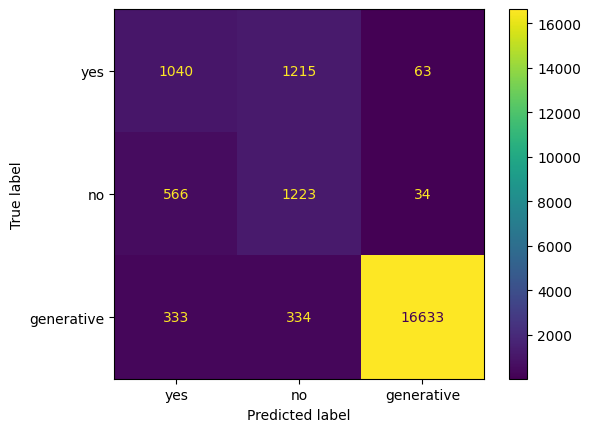

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(outputs["yng_label"], outputs["pred_yng_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["yes", "no", "generative"])
disp.plot()
plt.show()

In [ ]:
steps_per_epoch = dataset.num_rows / config.batch_size
total_steps = steps_per_epoch * config.num_epochs

print("steps_per_epoch:", steps_per_epoch)
print("total_steps:", total_steps)

NameError: name 'dataset' is not defined

In [ ]:
np.unique(get_data("train", config)["yng_label"], return_counts=True)

(array([0, 1, 2]), array([ 9481,  7287, 68806], dtype=int64))